<a href="https://colab.research.google.com/github/2667schummr/recurrent-nn-cystic-fibrosis/blob/total-no-na/cf_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from google.colab import drive
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
# Specify training parameters
device = '/device:GPU:0'
print_every = 100
batch_size = 100

In [0]:
# Make google drive files accessible
drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/Colab Notebooks/full-data-rnn'
os.chdir(path)
print('Current Working Directory: {}'.format(os.getcwd()))
from utils import *

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Current Working Directory: /content/gdrive/My Drive/Colab Notebooks/full-data-rnn


## Data Description
This dataset consists of observations made throughout the entire time period patients were tracked like the dataset used in notebook 1.  But, instead of dropping all incomplete features, the features that were 80% complete were kept and time steps with missing data were dropped.

In [0]:
# Load the panda dataframe containing the features used to train the simple RNN
# and multi-layer LSTM in the previous notebook
feats = pd.read_pickle('../cf-data/processed_data_complete_feats.pkl')
print('Feature Shape: {}'.format(feats.shape))

drop_cols = ['eDWID', 'YRM'] # These are identification columns
feats.head()

Feature Shape: (513452, 34)


,eDWID,YRM,mssa,mrsa,h_flu,pseudo,burkho_complex,alcalig,steno,enterobacter,serratia_marcescens,aspergillus,candida,scedosporium,mabscessus,mai,bd_age,sex,suff,trunc03,all_tob,all_mod,all_bd,dnase,inhcolistin,inhaztreonam,hypersaline,chronic_macrolide,oral_steroids,inh_steroids,inhsteroids_bronchodil,oral_other_abx,txflag,othertx
0,900000702,2003,0,0,0,1,0,0,0,0,0,1,0,0,0,0,6,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0
1,900000702,2004,0,0,0,1,0,0,0,0,0,0,0,0,0,0,7,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
2,900000702,2005,0,0,0,1,0,0,0,0,0,1,0,0,0,0,8,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
3,900000702,2006,0,0,0,1,0,0,0,0,0,1,0,0,0,0,9,0,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,0
4,900000702,2007,0,0,0,1,0,0,0,0,0,1,0,0,0,0,10,0,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,0


In [0]:
# Load the total dataset
data_train = pd.read_csv('../cf-data/total_training_no_na.csv')
data_test = pd.read_csv('../cf-data/total_testing_no_na.csv')
data_total = pd.concat([data_train, data_test], axis=0)
print('Feature Shape: {}'.format(data_total.shape))

Feature Shape: (1728227, 56)


In [0]:
# Keep only original features
feats = data_total[feats.columns]
max_seq_length = feats.groupby('eDWID').count()['YRM'].max()
print(feats.shape)

(1728227, 34)


In [0]:
# Extract the binary features
excluded_cols = ['dflag', 'dflag5']
for col in data_total.columns:
  num_unique = data_total[col].nunique()
  if col not in feats.columns and num_unique == 2 and col not in excluded_cols:
    feats[col] = data_total[col]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [0]:
# Add non-categorical features
cols = ['fev1pct_best', 'zscore_best', 'NumCult', 'nextNumCult']
for col in cols:
  feats[col] = data_total[col]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
# one-hot-encode trunc03 feature
feats = pd.get_dummies(feats, columns=['trunc03'])
num_feats = feats.shape[1] - 2
feats.head()

,eDWID,YRM,mssa,mrsa,h_flu,pseudo,burkho_complex,alcalig,steno,enterobacter,serratia_marcescens,aspergillus,candida,scedosporium,mabscessus,mai,bd_age,sex,suff,all_tob,all_mod,all_bd,dnase,inhcolistin,inhaztreonam,hypersaline,chronic_macrolide,oral_steroids,inh_steroids,inhsteroids_bronchodil,oral_other_abx,txflag,othertx,diabet,impglu,gainburkho_complex,gainalcalig,gainenterobacter,gainserratia_marcescens,gainscedosporium,gainmabscessus,gainmai,fev1pct_best,zscore_best,NumCult,nextNumCult,trunc03_0,trunc03_1,trunc03_2,trunc03_3,trunc03_4,trunc03_5
0,900000702,2003,0,0,0,1,0,0,0,0,0,1,0,0,0,0,6,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,135.283454,-0.673408,5,3,0,1,0,0,0,0
1,900000702,2003,0,0,0,1,0,0,0,0,0,1,0,0,0,0,6,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,135.283454,-0.673408,5,3,0,1,0,0,0,0
2,900000702,2003,0,0,0,1,0,0,0,0,0,1,0,0,0,0,6,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,135.283454,-0.673408,5,3,0,1,0,0,0,0
3,900000702,2003,0,0,0,1,0,0,0,0,0,1,0,0,0,0,6,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,135.283454,-0.673408,5,3,0,1,0,0,0,0
4,900000702,2003,0,0,0,1,0,0,0,0,0,1,0,0,0,0,6,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,135.283454,-0.673408,5,3,0,1,0,0,0,0


In [0]:
# Extract the patient labels
labels = data_total[['eDWID', 'dflag']].drop_duplicates()
print('Labels Shape: {}'.format(labels.shape))
num_obs = labels.shape[0]
labels.head()

Labels Shape: (38111, 2)


,eDWID,dflag
0,900000702,0
61,900000736,0
65,900000742,1
125,900000776,0
126,900010736,0


In [0]:
# Split the data into training and testing sets and create Dataset objects 
# and oversample training data for class balance
labels = labels.sample(frac=1)
labels_train, labels_test = train_test_split(labels, test_size=0.2, shuffle=False)

ros = RandomOverSampler()
X, y = ros.fit_resample(labels_train['eDWID'].as_matrix().reshape((-1, 1)), 
                        labels_train['dflag'])
labels_train = pd.DataFrame({'eDWID': X.reshape((-1,)), 'dflag': y})

patient_batches_train = Dataset(labels_train, batch_size, shuffle=True)
patient_batches_test = Dataset(labels_test, batch_size, shuffle=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/content/gdrive/My Drive/Colab Notebooks/full-data-rnn/utils.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.X = labels['eDWID'].as_matrix()
/content/gdrive/My Drive/Colab Notebooks/full-data-rnn/utils.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.y = labels['dflag'].as_matrix()


Means Deaths per Batch 0.5001163542340012



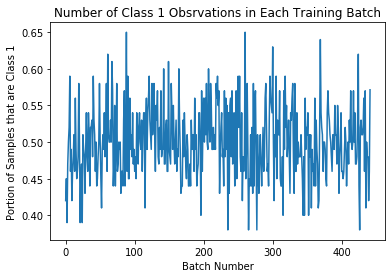

In [0]:
deaths_per_batch = []
batch_num = []
for i, (patients, patient_labels) in enumerate(patient_batches_train):
  deaths_per_batch.append(patient_labels.sum() / patient_labels.shape[0])
  batch_num.append(i)

plt.plot(batch_num, deaths_per_batch);
mean_deaths_per_batch = np.array(deaths_per_batch).mean()
print('Means Deaths per Batch {}\n'.format(mean_deaths_per_batch))
plt.title('Number of Class 1 Obsrvations in Each Training Batch');
plt.xlabel('Batch Number');
plt.ylabel('Portion of Samples that are Class 1');

In [0]:
one_class_freq_train = labels_train['dflag'].mean()
one_class_freq_test = labels_test['dflag'].mean()
print('1 Class Frequency for Training: {}'.format(one_class_freq_train))
print('1 Class Frequency for Test: {}'.format(one_class_freq_test))

1 Class Frequency for Training: 0.5
1 Class Frequency for Test: 0.2784992784992785


## Multi-Layer LSTM RNN plus a Fully Connected Network
This architecture consists of two RNN layers with LSTM cells.  The first layer outputs a sequence of vectors of size 500.  The second layer processes the vector sequence and outputs a single vector also of size 500.  This vector is then passed to a fully-connected network with one hidden layer of size 500 with ReLU activations.  The output space of the fully-connected network has a size of 2 corresponding to the class scores. 

In [0]:
# Define the model and optimize and train the model
def model_init_fn(inputs, is_training, seq_filter):
    layers = [tf.keras.layers.LSTM(500,
                                   batch_input_shape=(None, max_seq_length, num_feats),
                                   return_sequences=True), 
              tf.keras.layers.LSTM(500, return_sequences=False),
              tf.keras.layers.Dense(500, activation='relu'),
              tf.keras.layers.Dense(2)]
    model = tf.keras.Sequential(layers)

    return model(inputs, mask=seq_filter, training=is_training) 

learning_rate = 1e-3
def optimizer_init_fn():
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    return optimizer

loss_history, perf_history = train(model_init_fn, optimizer_init_fn, 
                                   max_seq_length, num_feats, patient_batches_train, 
                                   patient_batches_test, batch_size, 
                                   feats, drop_cols, labels, print_every, num_epochs=1)



Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





Starting epoch 0


/content/gdrive/My Drive/Colab Notebooks/full-data-rnn/utils.py:36: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  patient_feats = patient_feats.as_matrix()
/content/gdrive/My Drive/Colab Notebooks/full-data-rnn/utils.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  Y[i] = labels[labels.eDWID == patient]['dflag'].as_matrix()[0]


Iteration 0, loss = 0.6677
Accuracy: Got 5273 / 7700 correct (68.48%)
Precision: Got 1869 / 2123.0 correct (88.0357983984927%)
True Negative Rate: Got 3404 / 5577.0 correct (61.03639949793796%)

Iteration 100, loss = 0.3054
Accuracy: Got 6317 / 7700 correct (82.04%)
Precision: Got 1700 / 2123.0 correct (80.07536504945831%)
True Negative Rate: Got 4617 / 5577.0 correct (82.78644432490586%)

Iteration 200, loss = 0.4491
Accuracy: Got 6329 / 7700 correct (82.19%)
Precision: Got 1912 / 2123.0 correct (90.06123410268488%)
True Negative Rate: Got 4417 / 5577.0 correct (79.20028689259459%)

Iteration 300, loss = 0.3689
Accuracy: Got 6491 / 7700 correct (84.30%)
Precision: Got 1860 / 2123.0 correct (87.61186999528968%)
True Negative Rate: Got 4631 / 5577.0 correct (83.03747534516765%)

Iteration 400, loss = 0.2995
Accuracy: Got 6492 / 7700 correct (84.31%)
Precision: Got 1817 / 2123.0 correct (85.5864342910975%)
True Negative Rate: Got 4675 / 5577.0 correct (83.82642998027613%)



## Performance Evaluation  
Like the multi-layer LSTM in notebook 1, the model converged rapidly.  The added features from the data did not appear to improve performance nor did the addition of the fully-connected layers.

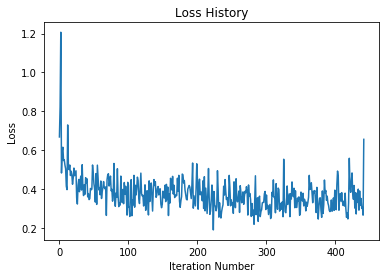

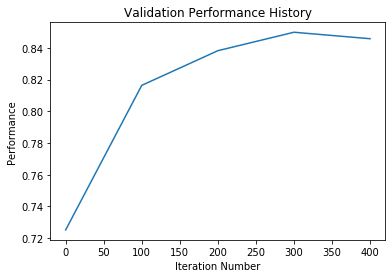

In [0]:
plt.figure()
plt.plot(range(len(loss_history)), loss_history);
plt.xlabel('Iteration Number');
plt.ylabel('Loss')
plt.title('Loss History');

plt.figure();
iterations = 100*np.array(range(len(perf_history)))
plt.plot(iterations, perf_history);
plt.title('Validation Performance History');
plt.xlabel('Iteration Number');
plt.ylabel('Performance');